In [1]:
import gc
import os
import string

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchinfo import summary

from collections import namedtuple
import PyPDF3

In [2]:
jtplot.style("gruvboxd")

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
device

device(type='cuda')

In [5]:
DATA_DIR = os.getcwd().replace('notebooks', 'data')

with open(os.path.join(DATA_DIR, 'anna.txt'), 'r') as file:
    text = file.read()

In [6]:
text[:120]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverything was in confusion i'

In [7]:
unique_chars = list(set(text))

In [8]:
len(unique_chars)

83

In [9]:
unique_chars

['c',
 '6',
 '4',
 'X',
 'N',
 '9',
 "'",
 '`',
 'O',
 'q',
 'v',
 '7',
 'S',
 '3',
 '1',
 'G',
 ':',
 '@',
 '8',
 'b',
 'g',
 '*',
 '0',
 ',',
 'U',
 'C',
 'Q',
 'a',
 'f',
 'p',
 'F',
 'o',
 'n',
 'A',
 'D',
 '"',
 '_',
 'z',
 'm',
 'r',
 ';',
 'B',
 '&',
 'e',
 'k',
 '(',
 '5',
 '.',
 'i',
 'L',
 '!',
 'M',
 '%',
 'Y',
 '?',
 'W',
 'w',
 'I',
 'V',
 '2',
 'R',
 'Z',
 'E',
 '/',
 'K',
 's',
 'j',
 ')',
 'h',
 'd',
 'u',
 'J',
 '\n',
 'l',
 '-',
 'P',
 ' ',
 't',
 'x',
 'T',
 '$',
 'y',
 'H']

In [10]:
chars2int = {char : unique_chars.index(char) for char in unique_chars}
int2char = {v : k for (k, v) in chars2int.items()}

In [11]:
def encode_text(text, unique_chars = None, extend = False):
    result_tuple = namedtuple('results', ['encoded_text', 'unique_char', 'int2char', 'char2int'])
    
    if unique_chars is None:
        unique_chars = list(set(text))
    else:
        if extend:
            unique_chars.extend(list('#[]{}+-*=!'))
        
    char2int = {char : unique_chars.index(char) for char in unique_chars}
    int2char = {v : k for (k, v) in char2int.items()}
    
    encoded_text = np.array(list(map(lambda x: char2int[x], list(text))))
    
    return result_tuple(encoded_text, unique_chars, int2char, char2int)

In [12]:
train_frac = 0.8
text, val_text = text[:int(len(text)*train_frac)], text[int(len(text)*(train_frac)):]

In [13]:
encoded_text, unique_chars, int2char, char2int = encode_text(text, unique_chars)

In [14]:
def one_hot_convert(arr, n_labels):
    nrows = arr.size
    array = np.zeros(shape = [nrows, n_labels])
    array[np.arange(array.shape[0]), arr.flatten()] = 1.
    
    return array

In [15]:
one_hot_convert(np.array([[1, 2, 3, 5]]), 10)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [16]:
batch_size = 32
seq_length = 16

In [17]:
numel_seq = batch_size * seq_length

In [18]:
numel_seq

512

In [19]:
encoded_text.shape[0]/numel_seq

3101.91015625

In [20]:
def batch_sequence(arr, batch_size, seq_length):
    numel_seq = batch_size * seq_length
    num_batches = arr.size // numel_seq
    
    arr = arr[: num_batches * numel_seq].reshape(batch_size, -1)
    #print(arr.shape)
    
    batched_data = [(arr[:, n : n + seq_length], arr[:, n + 1 : n + 1 + seq_length])
                    for n in range(0, arr.shape[1], seq_length)]
    
    ### Finalize final array size
    batched_data[-1] = (batched_data[-1][0],
                        np.append(batched_data[-1][1], batched_data[0][1][:, 0].reshape(-1, 1), axis = 1))
    
    ###batched_arr = [arr[n : n + numel_seq].reshape(batch_size, seq_length) for n in range(num_batches)]
    return iter(batched_data), num_batches

In [21]:
batch, _ = batch_sequence(encoded_text, 32, 16)

In [22]:
X, y = next(batch)

In [23]:
X

array([[25, 68, 27, 29, 77, 43, 39, 76, 14, 72, 72, 72, 82, 27, 29, 29],
       [43, 76, 68, 27, 69, 76, 28, 31, 39, 20, 31, 77, 77, 43, 32, 76],
       [77, 39, 27, 20, 43, 69, 81, 76, 48, 32, 72, 48, 77, 47, 35, 72],
       [77, 76, 68, 43, 39, 76, 56, 48, 77, 68, 76, 38, 43, 23, 76, 27],
       [43, 48, 39, 76, 68, 31, 65, 77, 72, 65, 38, 48, 73, 43, 69, 76],
       [43, 77, 43, 39, 65, 19, 70, 39, 20, 23, 76, 27, 65, 76, 65, 31],
       [65, 68, 43, 76, 56, 68, 48, 65, 29, 43, 39, 43, 69, 76, 29, 43],
       [28, 39, 31, 38, 76, 68, 43, 39, 76, 77, 31, 32, 43, 76, 77, 68],
       [28, 31, 39, 43, 47, 72, 72, 35, 82, 27, 10, 43, 76, 81, 31, 70],
       [56, 27, 65, 76,  0, 31, 38, 29, 73, 43, 77, 43, 73, 81, 76, 27],
       [43, 76, 33, 73, 43, 78, 43, 81, 76, 33, 73, 43, 78, 27, 32, 69],
       [68, 27, 69, 76, 28, 43, 73, 77, 76, 27, 77, 76, 48, 77, 47, 76],
       [29, 76, 77, 68, 43, 76, 73, 27, 65, 77, 76, 73, 48, 32, 43, 23],
       [81, 76, 56, 68, 48,  0, 68, 76,  0, 68, 48,

In [24]:
y

array([[68, 27, 29, 77, 43, 39, 76, 14, 72, 72, 72, 82, 27, 29, 29, 81],
       [76, 68, 27, 69, 76, 28, 31, 39, 20, 31, 77, 77, 43, 32, 76, 77],
       [39, 27, 20, 43, 69, 81, 76, 48, 32, 72, 48, 77, 47, 35, 72, 72],
       [76, 68, 43, 39, 76, 56, 48, 77, 68, 76, 38, 43, 23, 76, 27, 32],
       [48, 39, 76, 68, 31, 65, 77, 72, 65, 38, 48, 73, 43, 69, 76, 27],
       [77, 43, 39, 65, 19, 70, 39, 20, 23, 76, 27, 65, 76, 65, 31, 31],
       [68, 43, 76, 56, 68, 48, 65, 29, 43, 39, 43, 69, 76, 29, 43, 32],
       [39, 31, 38, 76, 68, 43, 39, 76, 77, 31, 32, 43, 76, 77, 68, 27],
       [31, 39, 43, 47, 72, 72, 35, 82, 27, 10, 43, 76, 81, 31, 70, 76],
       [27, 65, 76,  0, 31, 38, 29, 73, 43, 77, 43, 73, 81, 76, 27, 73],
       [76, 33, 73, 43, 78, 43, 81, 76, 33, 73, 43, 78, 27, 32, 69, 39],
       [27, 69, 76, 28, 43, 73, 77, 76, 27, 77, 76, 48, 77, 47, 76, 82],
       [76, 77, 68, 43, 76, 73, 27, 65, 77, 76, 73, 48, 32, 43, 23, 76],
       [76, 56, 68, 48,  0, 68, 76,  0, 68, 48, 73,

In [25]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [26]:
len(unique_chars)

83

In [27]:
#X_ = one_hot_convert(X, 90)
X_ = one_hot_encode(X, len(unique_chars))

In [28]:
X.shape

(32, 16)

In [29]:
X_.shape

(32, 16, 83)

\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}

In [30]:
print(help(nn.LSTM))

Help on class LSTM in module torch.nn.modules.rnn:

class LSTM(RNNBase)
 |  LSTM(*args, **kwargs)
 |  
 |  Applies a multi-layer long short-term memory (LSTM) RNN to an input
 |  sequence.
 |  
 |  
 |  For each element in the input sequence, each layer computes the following
 |  function:
 |  
 |  .. math::
 |      \begin{array}{ll} \\
 |          i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
 |          f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
 |          g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
 |          o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
 |          c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
 |          h_t = o_t \odot \tanh(c_t) \\
 |      \end{array}
 |  
 |  where :math:`h_t` is the hidden state at time `t`, :math:`c_t` is the cell
 |  state at time `t`, :math:`x_t` is the input at time `t`, :math:`h_{t-1}`
 |  is the hidden state of the layer at time `t-1` or the initial hidden
 |  state a

In [31]:
def get_text(fpath, start_page = 1):
    with open(fpath, "rb") as f:
        pdf = PyPDF3.PdfFileReader(f)
        text = str()
        for page_num in range(start_page-1, pdf.numPages):
            page = pdf.getPage(page_num)
            text = text + ' ' + page.extractText()
    return text.lower()

In [32]:
len(text)

1588178

In [33]:
len(val_text)

397045

In [34]:
print(val_text[:1000])

at it may be, but still it ought to be treated a little more
respectfully. Snetkov, now.... We may be of use, or we may not, but
we're the growth of a thousand years. If we're laying out a garden,
planning one before the house, you know, and there you've a tree that's
stood for centuries in the very spot.... Old and gnarled it may be, and
yet you don't cut down the old fellow to make room for the flowerbeds,
but lay out your beds so as to take advantage of the tree. You won't
grow him again in a year," he said cautiously, and he immediately
changed the conversation. "Well, and how is your land doing?"

"Oh, not very well. I make five per cent."

"Yes, but you don't reckon your own work. Aren't you worth something
too? I'll tell you my own case. Before I took to seeing after the land,
I had a salary of three hundred pounds from the service. Now I do more
work than I did in the service, and like you I get five per cent. on the
land, and thank God for that. But one's work is thrown in for

In [35]:
### Encode validation data
encoding_results = encode_text(val_text, unique_chars)
encoded_val = encoding_results.encoded_text

In [36]:
unique_char = encoding_results.unique_char
len(unique_char)

83

\begin{aligned}
 |              N ={} & \text{batch size} \\
 |              L ={} & \text{sequence length} \\
 |              D ={} & 2 \text{ if bidirectional=True otherwise } 1 \\
 |              H_{in} ={} & \text{input\_size} \\
 |              H_{cell} ={} & \text{hidden\_size} \\
 |              H_{out} ={} & \text{proj\_size if } \text{proj\_size}>0 \text{ otherwise hidden\_size} \\
 |          \end{aligned}

In [37]:
import torch
from torch import nn

class CharRNN(nn.Module):
    """
    Character-level LSTM.
    
    Parameters
    ----------
    input_size:
        Input (feature sze) for RNN.
    output_size:
        Input (feature sze) for RNN.
    hidden_size:
        Number of output features for RNN.
    dropout_rate:
        Dropout probability for RNN.
    batch_size:
        Number of sequences in a batch.
    D:
        Number of directions: uni- or bidirectional architecture for RNN.
    num_layers:
        Number of RNN stacks.
    batch_size:
        Number of sequences in a batch.
    
    Returns
    -------
    output:
        Shape: [batch_size, sequence_length, num_features]
    hidden_state:
        Tuple containing:
        - Short-term hidden state
            Shape: [batch_size, sequence_length, num_features]
        - Cell state
            Shape: [batch_size, sequence_length, num_features]
    
    """
    def __init__(self, input_size = 32, hidden_size = 128, dropout = 0.25,
                 batch_size = 32, D = 1, num_layers = 2, output_size = 32, base_rnn = nn.LSTM):
        
        super(CharRNN, self).__init__()
        
        self.base_rnn = base_rnn
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.D = D
        
        self.rnn = self.base_rnn(input_size = self.input_size, hidden_size = self.hidden_size,
                                dropout = self.dropout_rate, batch_first = True,
                                bidirectional = True if self.D == 2 else False, bias = True,
                                num_layers = self.num_layers)
        
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.D*self.hidden_size, self.output_size)
        
    def forward(self, x, hidden_state):
        outputs, hidden_state = self.rnn(x, hidden_state)
        outputs = self.dropout(outputs)
        outputs = outputs.contiguous().view(-1, self.D*self.hidden_size)
        outputs = self.fc(outputs)
        
        return outputs, hidden_state
    
    def init_hidden_state(self, mean = 0, stddev = 0):
        """
        Initialize hidden state and context tensors.
        """
        h = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
        h = h.to(device)
        
        if self.base_rnn == nn.LSTM:
            c = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
            c = c.to(device)
            h = (h, c)
        
        return h

In [38]:
batch_size = 128
seq_length = 100
num_layers = 2
hidden_size = 512

max_norm = 15
epochs = 30
lr = 1e-3

In [39]:
model = CharRNN(D = 1, dropout = 0.5, num_layers = num_layers, base_rnn = nn.LSTM,
                batch_size = batch_size, hidden_size = hidden_size,
                input_size = len(unique_char), output_size = len(unique_char)).to(device)

In [40]:
print(model)

CharRNN(
  (rnn): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


In [41]:
### Objective functions and optimizer
opt = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [42]:
gc.collect()

0

In [43]:
### Train data
_, num_batches = batch_sequence(encoded_text, batch_size, seq_length)

In [44]:
### Validation data
_, num_batches_ = batch_sequence(encoded_val, batch_size, seq_length)

In [45]:
### Num of train batches
print(num_batches)

124


In [46]:
### Num of valid batches
print(num_batches_)

31


In [47]:
running_train_loss = list()
running_val_loss = list()

### Outer training loop
for epoch in range(1, epochs + 1):
    h = model.init_hidden_state(mean = 0., stddev = .5)
    iteration = 0
    train_losses = list()
    
    ### Inner training loop
    for X, y in batch_sequence(encoded_text, batch_size, seq_length)[0]:
        X = one_hot_encode(X, len(unique_char))
        X, y = torch.as_tensor(X).to(device), torch.as_tensor(y).to(device)
        
        model.train()
        iteration += 1
        
        h = tuple([each.data for each in h])
        opt.zero_grad()
        
        outputs, h = model(X, h)
        
        loss = criterion(outputs, y.reshape(-1,).long())
        
        loss.backward(retain_graph = True)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        opt.step()
        
        train_losses.append(loss.detach().cpu().item())
        
        ### Outer validation loop
        if (not iteration % 20) or (iteration == num_batches):
            i = 0
            val_losses = list()
            model.eval()
            val_h = model.init_hidden_state(mean = 0., stddev = .5)
            
            ### Inner validation loop
            with torch.inference_mode():
                for X_, y_ in batch_sequence(encoded_val, batch_size, seq_length)[0]:
                    i += 1

                    val_h = tuple([each.data for each in val_h])

                    X_ = torch.as_tensor(one_hot_encode(X_, len(unique_chars))).to(device)
                    y_ = torch.as_tensor(y_).to(device)

                    outputs_, val_h = model(X_, val_h)

                    val_loss = criterion(outputs_, y_.reshape(-1,).long())
                    val_losses.append(val_loss.detach().cpu().item())

                ### Report training and validation losses
                val_loss = torch.Tensor(val_losses).mean().item()

                train_loss = torch.Tensor(train_losses).mean().item()
            
            running_train_loss.append(train_loss)
            running_val_loss.append(val_loss)
            
            print('='*80+"\n")
            print(f'Epoch: {epoch}/{epochs}, Iteration {iteration}/{num_batches},',
                  f'Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
    print('\n'+'='*80)
    print('='*80)
    print('='*80)
    #print('='*60)
    #print(f'Epoch: {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}\n')
    #print('='*60)


Epoch: 1/30, Iteration 20/124, Train Loss: 3.4588, Valid Loss: 3.1336

Epoch: 1/30, Iteration 40/124, Train Loss: 3.2964, Valid Loss: 3.1196

Epoch: 1/30, Iteration 60/124, Train Loss: 3.2375, Valid Loss: 3.1143

Epoch: 1/30, Iteration 80/124, Train Loss: 3.2040, Valid Loss: 3.0985

Epoch: 1/30, Iteration 100/124, Train Loss: 3.1752, Valid Loss: 3.0105

Epoch: 1/30, Iteration 120/124, Train Loss: 3.1344, Valid Loss: 2.8274

Epoch: 1/30, Iteration 124/124, Train Loss: 3.1242, Valid Loss: 2.7818


Epoch: 2/30, Iteration 20/124, Train Loss: 2.7002, Valid Loss: 2.5763

Epoch: 2/30, Iteration 40/124, Train Loss: 2.6154, Valid Loss: 2.4575

Epoch: 2/30, Iteration 60/124, Train Loss: 2.5578, Valid Loss: 2.3881

Epoch: 2/30, Iteration 80/124, Train Loss: 2.5123, Valid Loss: 2.3328

Epoch: 2/30, Iteration 100/124, Train Loss: 2.4758, Valid Loss: 2.2740

Epoch: 2/30, Iteration 120/124, Train Loss: 2.4418, Valid Loss: 2.2241

Epoch: 2/30, Iteration 124/124, Train Loss: 2.4352, Valid Loss: 2.2064


Epoch: 7/30, Iteration 80/124, Train Loss: 1.6057, Valid Loss: 1.5469

Epoch: 7/30, Iteration 100/124, Train Loss: 1.6030, Valid Loss: 1.5383

Epoch: 7/30, Iteration 120/124, Train Loss: 1.5978, Valid Loss: 1.5290

Epoch: 7/30, Iteration 124/124, Train Loss: 1.5962, Valid Loss: 1.5260


Epoch: 8/30, Iteration 20/124, Train Loss: 1.5652, Valid Loss: 1.5169

Epoch: 8/30, Iteration 40/124, Train Loss: 1.5518, Valid Loss: 1.5099

Epoch: 8/30, Iteration 60/124, Train Loss: 1.5480, Valid Loss: 1.5008

Epoch: 8/30, Iteration 80/124, Train Loss: 1.5455, Valid Loss: 1.4937

Epoch: 8/30, Iteration 100/124, Train Loss: 1.5435, Valid Loss: 1.4876

Epoch: 8/30, Iteration 120/124, Train Loss: 1.5390, Valid Loss: 1.4823

Epoch: 8/30, Iteration 124/124, Train Loss: 1.5378, Valid Loss: 1.4810


Epoch: 9/30, Iteration 20/124, Train Loss: 1.5138, Valid Loss: 1.4711

Epoch: 9/30, Iteration 40/124, Train Loss: 1.5016, Valid Loss: 1.4628

Epoch: 9/30, Iteration 60/124, Train Loss: 1.4990, Valid Loss: 1.457


Epoch: 13/30, Iteration 120/124, Train Loss: 1.3697, Valid Loss: 1.3478

Epoch: 13/30, Iteration 124/124, Train Loss: 1.3688, Valid Loss: 1.3504


Epoch: 14/30, Iteration 20/124, Train Loss: 1.3613, Valid Loss: 1.3416

Epoch: 14/30, Iteration 40/124, Train Loss: 1.3504, Valid Loss: 1.3411

Epoch: 14/30, Iteration 60/124, Train Loss: 1.3494, Valid Loss: 1.3386

Epoch: 14/30, Iteration 80/124, Train Loss: 1.3502, Valid Loss: 1.3383

Epoch: 14/30, Iteration 100/124, Train Loss: 1.3506, Valid Loss: 1.3343

Epoch: 14/30, Iteration 120/124, Train Loss: 1.3483, Valid Loss: 1.3325

Epoch: 14/30, Iteration 124/124, Train Loss: 1.3474, Valid Loss: 1.3338


Epoch: 15/30, Iteration 20/124, Train Loss: 1.3367, Valid Loss: 1.3275

Epoch: 15/30, Iteration 40/124, Train Loss: 1.3287, Valid Loss: 1.3272

Epoch: 15/30, Iteration 60/124, Train Loss: 1.3285, Valid Loss: 1.3281

Epoch: 15/30, Iteration 80/124, Train Loss: 1.3298, Valid Loss: 1.3264

Epoch: 15/30, Iteration 100/124, Train Loss: 1.3301, Val


Epoch: 20/30, Iteration 20/124, Train Loss: 1.2636, Valid Loss: 1.2778

Epoch: 20/30, Iteration 40/124, Train Loss: 1.2543, Valid Loss: 1.2782

Epoch: 20/30, Iteration 60/124, Train Loss: 1.2548, Valid Loss: 1.2825

Epoch: 20/30, Iteration 80/124, Train Loss: 1.2568, Valid Loss: 1.2785

Epoch: 20/30, Iteration 100/124, Train Loss: 1.2576, Valid Loss: 1.2767

Epoch: 20/30, Iteration 120/124, Train Loss: 1.2562, Valid Loss: 1.2744

Epoch: 20/30, Iteration 124/124, Train Loss: 1.2557, Valid Loss: 1.2788


Epoch: 21/30, Iteration 20/124, Train Loss: 1.2527, Valid Loss: 1.2724

Epoch: 21/30, Iteration 40/124, Train Loss: 1.2435, Valid Loss: 1.2711

Epoch: 21/30, Iteration 60/124, Train Loss: 1.2436, Valid Loss: 1.2739

Epoch: 21/30, Iteration 80/124, Train Loss: 1.2457, Valid Loss: 1.2690

Epoch: 21/30, Iteration 100/124, Train Loss: 1.2460, Valid Loss: 1.2678

Epoch: 21/30, Iteration 120/124, Train Loss: 1.2444, Valid Loss: 1.2677

Epoch: 21/30, Iteration 124/124, Train Loss: 1.2439, Vali


Epoch: 26/30, Iteration 60/124, Train Loss: 1.1832, Valid Loss: 1.2315

Epoch: 26/30, Iteration 80/124, Train Loss: 1.1860, Valid Loss: 1.2337

Epoch: 26/30, Iteration 100/124, Train Loss: 1.1867, Valid Loss: 1.2295

Epoch: 26/30, Iteration 120/124, Train Loss: 1.1858, Valid Loss: 1.2331

Epoch: 26/30, Iteration 124/124, Train Loss: 1.1854, Valid Loss: 1.2317


Epoch: 27/30, Iteration 20/124, Train Loss: 1.1823, Valid Loss: 1.2309

Epoch: 27/30, Iteration 40/124, Train Loss: 1.1737, Valid Loss: 1.2402

Epoch: 27/30, Iteration 60/124, Train Loss: 1.1744, Valid Loss: 1.2265

Epoch: 27/30, Iteration 80/124, Train Loss: 1.1764, Valid Loss: 1.2276

Epoch: 27/30, Iteration 100/124, Train Loss: 1.1766, Valid Loss: 1.2286

Epoch: 27/30, Iteration 120/124, Train Loss: 1.1756, Valid Loss: 1.2287

Epoch: 27/30, Iteration 124/124, Train Loss: 1.1751, Valid Loss: 1.2275


Epoch: 28/30, Iteration 20/124, Train Loss: 1.1765, Valid Loss: 1.2240

Epoch: 28/30, Iteration 40/124, Train Loss: 1.1662, Val

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


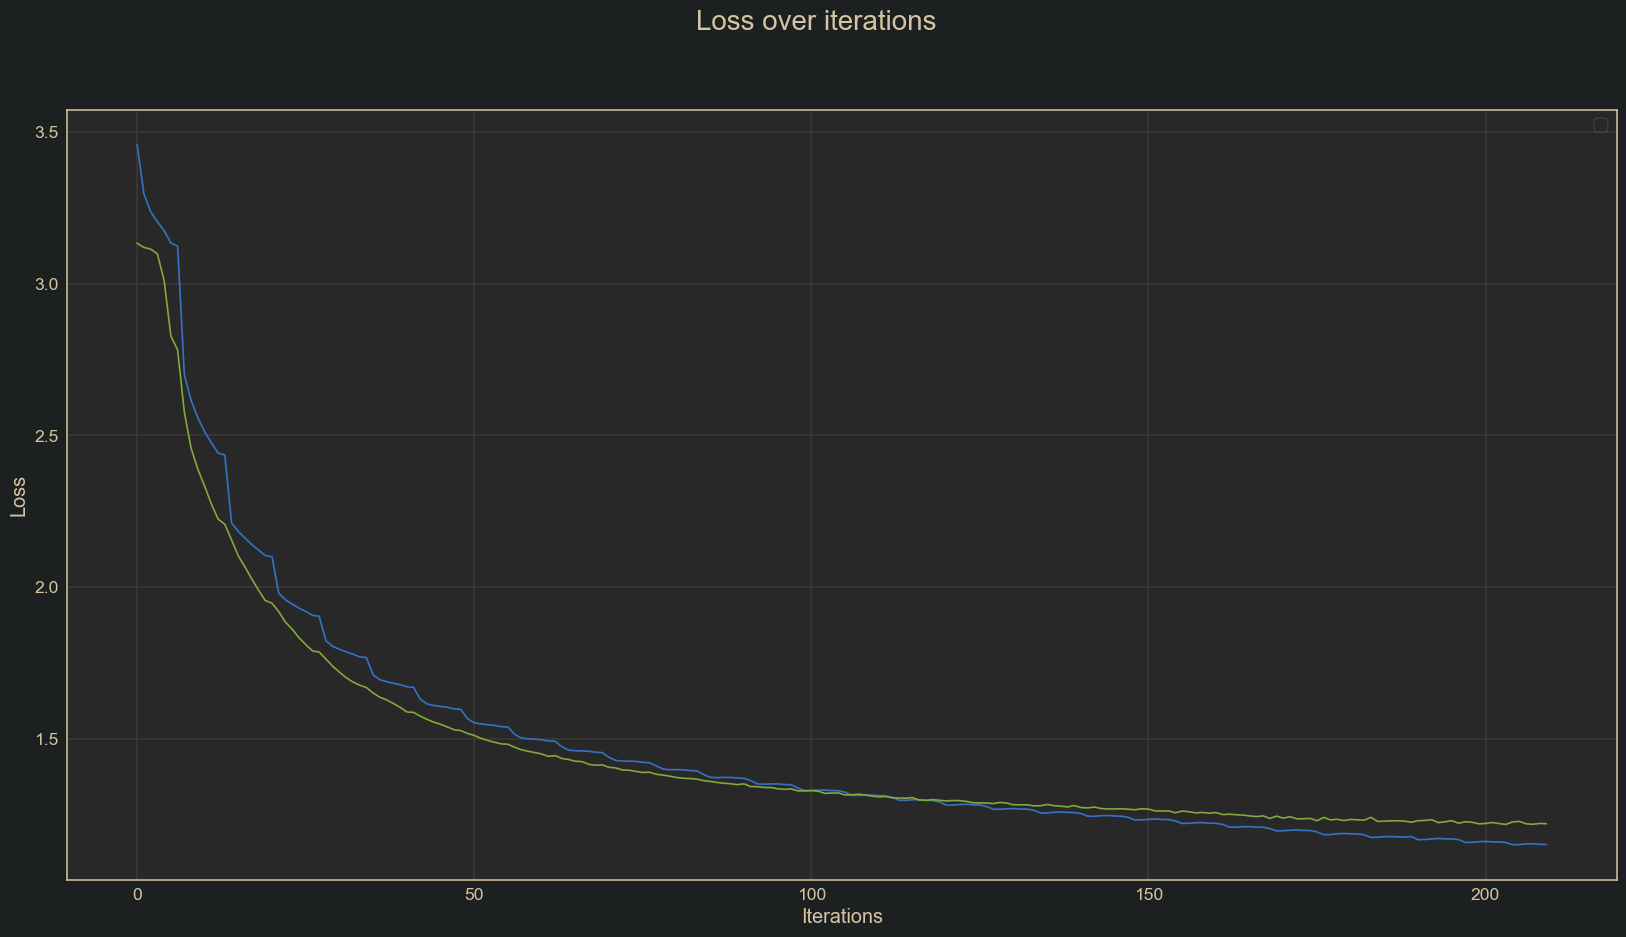

In [48]:
plt.figure(figsize = (20, 10))
plt.plot(range(len(running_train_loss)), running_train_loss, range(len(running_val_loss)), running_val_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.suptitle("Loss over iterations", fontsize = 20)
plt.legend()
plt.show(); plt.close("all")

In [49]:
### Freeze model weights
model.requires_grad_ = False

In [50]:
int2char = encoding_results.int2char
char2int = encoding_results.char2int

In [51]:
seed = "Lan al'Mandragoran went up the mountain"
k = 5

In [52]:
def predict(x, h, net, k = 5):
    x = np.array([[char2int[x]]])
    x = one_hot_encode(x, len(unique_chars))
    x = torch.from_numpy(x).to(device).contiguous()
    
    out, h = net(x, h)
    p = F.softmax(out, dim = -1).data
    p, chars = p.topk(k, dim = -1)
    
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    
    return np.random.choice(chars, p = p/p.sum()), h

In [53]:
a = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_()
b = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_()
h = (a.to(device), b.to(device))

predict("D", h, model, 5)

(31,
 (tensor([[[-0.2563,  0.1587, -0.0292,  ...,  0.1180, -0.1307, -0.1406]],
  
          [[-0.3493,  0.0173, -0.0934,  ...,  0.1343, -0.0358,  0.0264]]],
         device='cuda:0', grad_fn=<CudnnRnnBackward0>),
  tensor([[[-0.4189,  0.2289, -0.0579,  ...,  0.2041, -0.1943, -0.2289]],
  
          [[-0.6287,  0.0338, -0.1095,  ...,  0.2256, -0.1362,  0.0742]]],
         device='cuda:0', grad_fn=<CudnnRnnBackward0>)))

In [54]:
seed_list = list(seed)

a = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
b = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
h = (a.to(device), b.to(device))

for char in seed_list:
    h = tuple([each.data for each in h])
    next_char, h = predict(char, h, model, k)

seed_list.append(int2char[next_char])
seed_list_1 = seed_list.copy()
seed_list_2 = seed_list.copy()

In [55]:
print(''.join(seed_list))

Lan al'Mandragoran went up the mountain



In [56]:
## Method 1
for ii in range(1000):
    h = tuple([each.data for each in h])
    next_char, h = predict(seed_list_1[-1], h, model, k)
    seed_list_1.append(int2char[next_char])

In [57]:
## Method 2
for ix in range(1000):
    h = tuple([each.data.to(device) for each in h])
    x = np.array(char2int[seed_list_2[-1]]).reshape(1, -1)
    x = one_hot_encode(x, len(unique_char))
    x = torch.tensor(x).to(device)
    out, h = model(x, h)
    
    p = F.softmax(out, dim=-1)
    p, chars = p.topk(k = k, dim=-1)
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    seed_list_2.append(int2char[np.random.choice(chars, p = p/p.sum())])
    #next_char = chars[torch.distributions.Uniform(low = 0, high = k).sample().to(torch.int32).item()].item()
    #seed_list.append(int2char[next_char])
    

In [58]:
pred_text = ''.join(seed_list_1)

In [59]:
print(pred_text)

Lan al'Mandragoran went up the mountain
of them. The conversation had been asked to a stranger, that there
could not be, who had been been to told him, and, too which as
he said a latter.

"You're telling me,' so much...."

"No, I'm so, but we haven't a sign of man is so incalled..." she said.

"Oh, I'm not a steps."

"Well, how so? What do you were at all?"

"Oh, no, I'm not a carriage," the pate of the painty convinced
that a little conclusion which he had struck her, and the moment
who could not see her white arrival, who would say to him.

After said it was the treat of winting the princess, and with a
smell of house and the lows that thrist, and taking off the day.

Anna came in with a position with her and her final compant. "I don't want
to be so always. Why do this? I've not going to see him.



Chapter 32


The shirt was happiness to tha pretermation in the sight of her,
but that she saw that his wife, and to her son which he had not said,
was not strange and same that the mat

In [60]:
pred_text = ''.join(seed_list_2)

In [61]:
print(pred_text)

Lan al'Mandragoran went up the mountain
Ivanovitch had said: "The party and a case we are not taking me the baby of
her, and so is the princess, which I don't know that,"
he thought.

She had now so mode of his beauty in the mind.

That shame was as soon as she had seemed about something at an agricurt,
between the strenche to her, and the peasant was a certain attancing sorrow above,
and the most of the sort of annoying this sensition with his brother had
a great men. He was a particularly pleasent that the motter said he was
thinking of the same thing. She said it was the same and the completion
of her more and more for the same, and that all the marshal shake
into the servant hoste to see him firm into the bird heart that
the beside, that it was a man and she went on, and with standing and sent to her
how had she could not lead her horses that he was not left her.

They were saying and sown to a conversation in which there was so
sure that she was taking of an act a single possibili